# Brain Tumor Detection
## Single Task Validation - Building Bounding Box Regressor
Description
This dataset was originally created by Yousef Ghanem. To see the current project, which may have been updated since this version, please go here: https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f.

This dataset is part of RF100, an Intel-sponsored initiative to create a new object detection benchmark for model generalizability.

Access the RF100 Github repo: https://github.com/roboflow-ai/roboflow-100-benchmark

## Imports

In [1]:
# Go to project root folder
import os
os.chdir("../")
%pwd

'/workspaces/brain-tumor-detection'

In [2]:
import numpy as np
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()

import tensorflow as tf
tf.random.set_seed(42)

import matplotlib.pyplot as plt

2025-03-17 13:42:54.458367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742218974.467401  110688 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742218974.469966  110688 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742218974.478780  110688 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742218974.478793  110688 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742218974.478795  110688 computation_placer.cc:177] computation placer alr

In [3]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.19.0')

In [4]:
from src.data_handler.data_loader import DataLoader
from src.data_handler.annotation_processor import AnnotationProcessor
from src.data_handler.preprocessor import Preprocessor

In [5]:
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths Setup

In [6]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/-Brain-Tumor-Detection-2/train/


In [7]:
cfg.DATASET_DIRS

{'TRAIN_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/train/', 'VALIDATION_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/valid', 'TEST_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/test'}

In [8]:
DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)


IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE
LOG_DIR = cfg.OUTPUTS.LOG_DIR
CHECK_POINT_DIR = Path(cfg.OUTPUTS.CHECKPOINT_PATH)
class_name_list = [
    'label0',
    'label1',
    'label2'
]
class_map = {k: v for k, v in enumerate(class_name_list)}

NUM_EPOCHS = cfg.TRAIN.NUM_EPOCHS
LEARNING_RATE = cfg.TRAIN.LEARNING_RATE

NUM_CLASSES = len(class_name_list)


## Dataset Download from Roboflow

In [ ]:
if not TRAIN_DIR.exists():
    from roboflow import Roboflow
    rf = Roboflow()
    project = rf.workspace("yousef-ghanem-jzj4y").project("brain-tumor-detection-fpf1f")
    version = project.version(2)
    dataset = version.download("tensorflow")
                        

## Load images from directory

### Load Training datasets

In [10]:
prepare_train_dataset = AnnotationProcessor(annotation_file= str(TRAIN_DIR/'_annotations.csv'))
_class_map = {v: k for k, v in enumerate(class_name_list)}
train_images, train_class_ids, train_bboxes  = prepare_train_dataset.process_annotations(image_dir=TRAIN_DIR, class_id_map=_class_map)

len(train_images), len(train_class_ids), len(train_bboxes)

(6851, 6851, 6851)

In [11]:
train_class_ids

[[0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1],
 [0, 1, 2],
 [0, 1, 2],
 [1, 2],
 [0, 1],
 [1],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [1, 2],
 [0, 1],
 [2],
 [1],
 [0, 1, 2],
 [1],
 [1],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1],
 [1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1],
 [0, 1, 2],
 [1],
 [0, 1],
 [0, 1, 2],
 [1],
 [1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [1],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2]

In [12]:
train_images[0],train_class_ids[0], train_bboxes[0]

('datasets/-Brain-Tumor-Detection-2/train/volume_201_slice_92_jpg.rf.0012bdce7561c3808ed18953dc75060c.jpg',
 [0, 1, 2],
 array([[0.68345324, 0.54545455, 0.95683453, 0.76515152],
        [0.42446043, 0.48484848, 0.99280576, 0.96969697],
        [0.46043165, 0.53030303, 0.99280576, 0.78030303]]))

In [13]:
train_dl = DataLoader(train_images, train_class_ids, train_bboxes)
train_ds = train_dl.load_train_dataset()
train_ds = Preprocessor(train_ds).preprocess()
train_ds = train_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

I0000 00:00:1742218988.818337  110688 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7192 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [14]:
for batch in train_ds.take(1):
    image, bbx = batch
    print(image.shape, bbx.shape)
    print(bbx[5])
    print(image[1].numpy().min(), image[1].numpy().max())


(64, 240, 240, 3) (64, 3, 4)
tf.Tensor(
[[0.676259   0.8484849  0.78417265 0.90909094]
 [0.52517986 0.65909094 0.8489209  0.9621212 ]
 [0.6618705  0.8030303  0.8057554  0.95454544]], shape=(3, 4), dtype=float32)
-123.68 151.061


2025-03-17 13:43:15.487517: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Validation datasets 

In [15]:
prepare_valid_dataset = AnnotationProcessor(annotation_file= str(VALIDATION_DIR/'_annotations.csv'))
valid_image_paths, valid_class_ids, valid_bboxes  = prepare_valid_dataset.process_annotations(image_dir=VALIDATION_DIR, class_id_map=_class_map)
len(valid_image_paths), len(valid_class_ids), len(valid_bboxes)

(1963, 1963, 1963)

In [16]:
valid_dl = DataLoader(valid_image_paths, valid_class_ids, valid_bboxes).load_val_dataset()
valid_ds = Preprocessor(valid_dl).preprocess()
valid_ds = valid_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

In [17]:
for batch in valid_ds.take(1):
    image, bbx, = batch
    print(bbx.shape)
    print(image.shape)
    print(image[1].numpy().min(), image[1].numpy().max(), bbx[0].numpy().min(), bbx[0].numpy().max())

(64, 3, 4)
(64, 240, 240, 3)
-123.68 138.49847 0.5539568 0.9928058


2025-03-17 13:43:16.936130: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training Setup

In [18]:
from src.losses import iou_loss
REG_METRICS = [
    iou_loss.iou_metric,
    tf.keras.metrics.MeanSquaredError(name='mse'),
]

### Define  Callbacks

In [19]:
import os

to_monitor = 'val_iou_metric'
mode = 'max'
callbacks = [
    # Learning Rate Scheduler
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor=to_monitor,
        factor=0.2,  # Less aggressive reduction
        patience=5,
        mode=mode,
        min_lr=1e-6,  # Higher minimum learning rate
        verbose=1
    ),
    
    # Model Checkpoint
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(CHECK_POINT_DIR, "best_reg_model.keras"),
        save_weights_only=False,
        save_best_only=True,
        monitor=to_monitor,
        mode=mode,
        verbose=1
    ),
    
    # Early Stopping
    tf.keras.callbacks.EarlyStopping(
        monitor=to_monitor,
        patience=15,  # Allow 3 LR reductions before stopping
        mode=mode,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Additional Recommendation
    tf.keras.callbacks.TensorBoard(
        log_dir='logs',
        histogram_freq=1  # Track gradients/weights
    )]

### Define Optimizer

In [20]:
optimizer=tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE,
                                    global_clipnorm=1.0)  # Prevent exploding gradients

## Define ResNet50 Model Regressor

In [21]:
from src.models.resnet101 import resnet101_regressor
import mlflow
tf.keras.backend.clear_session()

mlflow.set_experiment("/brain-tumor-resnet101_regressor-IoU-loss")
mlflow.tensorflow.autolog(log_models=True, 
                          log_datasets=False, 
                          log_input_examples=True,
                          keras_model_kwargs={"save_format": "keras"},
                          checkpoint_monitor=to_monitor, 
                          checkpoint_mode=mode)

model = resnet101_regressor(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=NUM_CLASSES)

model.summary()

2025/03/17 13:43:19 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.18.0, but the installed version is 2.19.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.


Total layers in ResNet101: 345
Unfreezing the last 103 layers (30% of total layers)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 246, 246,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 120, 120,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 120, 120,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 120, 120,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 122, 122,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 60, 60,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 60, 60,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 60, 60,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 60, 60,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 60, 60,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 60, 60,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 60, 60,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 60, 60,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 60, 60,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 60, 60,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 60, 60,    │      1,024 │ conv2_block1_3_c

 Total params: 45,287,308 (172.76 MB)

 Trainable params: 25,436,172 (97.03 MB)

 Non-trainable params: 19,851,136 (75.73 MB)

## Model Building and Compilation

In [22]:
from src.losses import iou_loss

model.compile(
    optimizer=optimizer,
    loss=iou_loss.iou_loss,
    metrics=REG_METRICS)  

## Train and Validate the model

In [23]:
history = model.fit(train_ds,
    epochs=NUM_EPOCHS,
    validation_data=valid_ds,
    batch_size=BATCH_SIZE,
    callbacks=callbacks)

2025/03/17 13:43:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7b754ad37dad4d2ca790d170e418202a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/50


I0000 00:00:1742219023.780077  110953 service.cc:152] XLA service 0x7d54c802a420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742219023.780168  110953 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-03-17 13:43:44.384696: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742219027.244707  110953 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1742219040.782184  110953 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - iou_metric: 0.0883 - loss: 18.6435 - mse: 0.1601
Epoch 1: val_iou_metric improved from -inf to 0.24321, saving model to output/checkpoints/best_reg_model.keras


108/108 ━━━━━━━━━━━━━━━━━━━━ 91s 492ms/step - iou_metric: 0.0887 - loss: 18.6206 - mse: 0.1600 - val_iou_metric: 0.2432 - val_loss: 11.7271 - val_mse: 0.0992 - learning_rate: 1.0000e-04
Epoch 2/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - iou_metric: 0.2479 - loss: 10.3941 - mse: 0.1231
Epoch 2: val_iou_metric improved from 0.24321 to 0.31242, saving model to output/checkpoints/best_reg_model.keras


108/108 ━━━━━━━━━━━━━━━━━━━━ 37s 292ms/step - iou_metric: 0.2484 - loss: 10.3717 - mse: 0.1230 - val_iou_metric: 0.3124 - val_loss: 6.9116 - val_mse: 0.0990 - learning_rate: 1.0000e-04
Epoch 3/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - iou_metric: 0.3295 - loss: 6.0959 - mse: 0.1017
Epoch 3: val_iou_metric improved from 0.31242 to 0.33960, saving model to output/checkpoints/best_reg_model.keras


108/108 ━━━━━━━━━━━━━━━━━━━━ 37s 287ms/step - iou_metric: 0.3296 - loss: 6.0825 - mse: 0.1017 - val_iou_metric: 0.3396 - val_loss: 4.0158 - val_mse: 0.0907 - learning_rate: 1.0000e-04
Epoch 4/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - iou_metric: 0.3688 - loss: 3.5325 - mse: 0.1046
Epoch 4: val_iou_metric improved from 0.33960 to 0.41360, saving model to output/checkpoints/best_reg_model.keras


108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 281ms/step - iou_metric: 0.3688 - loss: 3.5251 - mse: 0.1046 - val_iou_metric: 0.4136 - val_loss: 2.3731 - val_mse: 0.0864 - learning_rate: 1.0000e-04
Epoch 5/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - iou_metric: 0.3854 - loss: 2.1625 - mse: 0.1028
Epoch 5: val_iou_metric did not improve from 0.41360
108/108 ━━━━━━━━━━━━━━━━━━━━ 33s 252ms/step - iou_metric: 0.3855 - loss: 2.1586 - mse: 0.1028 - val_iou_metric: 0.3988 - val_loss: 1.5632 - val_mse: 0.0914 - learning_rate: 1.0000e-04
Epoch 6/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - iou_metric: 0.4028 - loss: 1.4390 - mse: 0.0994
Epoch 6: val_iou_metric did not improve from 0.41360
108/108 ━━━━━━━━━━━━━━━━━━━━ 33s 259ms/step - iou_metric: 0.4029 - loss: 1.4370 - mse: 0.0994 - val_iou_metric: 0.4088 - val_loss: 1.1433 - val_mse: 0.0980 - learning_rate: 1.0000e-04
Epoch 7/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - iou_metric: 0.4199 - loss: 1.0719 - mse: 0.1031
Epoch 7: val_iou_metric improv

108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 280ms/step - iou_metric: 0.4199 - loss: 1.0709 - mse: 0.1030 - val_iou_metric: 0.4507 - val_loss: 0.8868 - val_mse: 0.0863 - learning_rate: 1.0000e-04
Epoch 8/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - iou_metric: 0.4278 - loss: 0.8762 - mse: 0.0990
Epoch 8: val_iou_metric did not improve from 0.45068
108/108 ━━━━━━━━━━━━━━━━━━━━ 34s 267ms/step - iou_metric: 0.4278 - loss: 0.8756 - mse: 0.0990 - val_iou_metric: 0.4470 - val_loss: 0.7726 - val_mse: 0.0865 - learning_rate: 1.0000e-04
Epoch 9/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - iou_metric: 0.4388 - loss: 0.7619 - mse: 0.0970
Epoch 9: val_iou_metric improved from 0.45068 to 0.45814, saving model to output/checkpoints/best_reg_model.keras


108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 288ms/step - iou_metric: 0.4388 - loss: 0.7616 - mse: 0.0971 - val_iou_metric: 0.4581 - val_loss: 0.6928 - val_mse: 0.0996 - learning_rate: 1.0000e-04
Epoch 10/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - iou_metric: 0.4405 - loss: 0.6993 - mse: 0.1012
Epoch 10: val_iou_metric improved from 0.45814 to 0.46187, saving model to output/checkpoints/best_reg_model.keras


108/108 ━━━━━━━━━━━━━━━━━━━━ 37s 293ms/step - iou_metric: 0.4405 - loss: 0.6990 - mse: 0.1012 - val_iou_metric: 0.4619 - val_loss: 0.6484 - val_mse: 0.0937 - learning_rate: 1.0000e-04
Epoch 11/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - iou_metric: 0.4493 - loss: 0.6543 - mse: 0.1005
Epoch 11: val_iou_metric did not improve from 0.46187
108/108 ━━━━━━━━━━━━━━━━━━━━ 34s 262ms/step - iou_metric: 0.4493 - loss: 0.6542 - mse: 0.1005 - val_iou_metric: 0.4462 - val_loss: 0.6390 - val_mse: 0.0894 - learning_rate: 1.0000e-04
Epoch 12/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - iou_metric: 0.4541 - loss: 0.6268 - mse: 0.0972
Epoch 12: val_iou_metric did not improve from 0.46187
108/108 ━━━━━━━━━━━━━━━━━━━━ 34s 268ms/step - iou_metric: 0.4542 - loss: 0.6267 - mse: 0.0972 - val_iou_metric: 0.4579 - val_loss: 0.6113 - val_mse: 0.0921 - learning_rate: 1.0000e-04
Epoch 13/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - iou_metric: 0.4644 - loss: 0.6016 - mse: 0.0958
Epoch 13: val_iou_metric 

108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 288ms/step - iou_metric: 0.4644 - loss: 0.6016 - mse: 0.0958 - val_iou_metric: 0.4804 - val_loss: 0.5776 - val_mse: 0.0976 - learning_rate: 1.0000e-04
Epoch 14/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - iou_metric: 0.4730 - loss: 0.5827 - mse: 0.1003
Epoch 14: val_iou_metric did not improve from 0.48044
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 272ms/step - iou_metric: 0.4730 - loss: 0.5827 - mse: 0.1002 - val_iou_metric: 0.4706 - val_loss: 0.5793 - val_mse: 0.0843 - learning_rate: 1.0000e-04
Epoch 15/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - iou_metric: 0.4702 - loss: 0.5785 - mse: 0.0938
Epoch 15: val_iou_metric did not improve from 0.48044
108/108 ━━━━━━━━━━━━━━━━━━━━ 34s 262ms/step - iou_metric: 0.4702 - loss: 0.5785 - mse: 0.0938 - val_iou_metric: 0.4662 - val_loss: 0.5785 - val_mse: 0.0987 - learning_rate: 1.0000e-04
Epoch 16/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - iou_metric: 0.4803 - loss: 0.5633 - mse: 0.0996
Epoch 16: val_iou_metric 

108/108 ━━━━━━━━━━━━━━━━━━━━ 37s 297ms/step - iou_metric: 0.4853 - loss: 0.5516 - mse: 0.0943 - val_iou_metric: 0.4828 - val_loss: 0.5523 - val_mse: 0.0922 - learning_rate: 1.0000e-04
Epoch 19/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - iou_metric: 0.4957 - loss: 0.5393 - mse: 0.0951
Epoch 19: val_iou_metric improved from 0.48280 to 0.48801, saving model to output/checkpoints/best_reg_model.keras


108/108 ━━━━━━━━━━━━━━━━━━━━ 37s 289ms/step - iou_metric: 0.4956 - loss: 0.5393 - mse: 0.0951 - val_iou_metric: 0.4880 - val_loss: 0.5452 - val_mse: 0.0878 - learning_rate: 1.0000e-04
Epoch 20/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - iou_metric: 0.4946 - loss: 0.5383 - mse: 0.0963
Epoch 20: val_iou_metric did not improve from 0.48801
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 269ms/step - iou_metric: 0.4946 - loss: 0.5382 - mse: 0.0963 - val_iou_metric: 0.4777 - val_loss: 0.5542 - val_mse: 0.1015 - learning_rate: 1.0000e-04
Epoch 21/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - iou_metric: 0.4956 - loss: 0.5364 - mse: 0.0990
Epoch 21: val_iou_metric did not improve from 0.48801
108/108 ━━━━━━━━━━━━━━━━━━━━ 33s 261ms/step - iou_metric: 0.4956 - loss: 0.5364 - mse: 0.0990 - val_iou_metric: 0.4854 - val_loss: 0.5454 - val_mse: 0.0889 - learning_rate: 1.0000e-04
Epoch 22/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - iou_metric: 0.4969 - loss: 0.5335 - mse: 0.0964
Epoch 22: val_iou_metric 

108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 287ms/step - iou_metric: 0.5014 - loss: 0.5288 - mse: 0.0958 - val_iou_metric: 0.4956 - val_loss: 0.5338 - val_mse: 0.0919 - learning_rate: 1.0000e-04
Epoch 24/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - iou_metric: 0.5094 - loss: 0.5199 - mse: 0.0950
Epoch 24: val_iou_metric did not improve from 0.49560
108/108 ━━━━━━━━━━━━━━━━━━━━ 33s 256ms/step - iou_metric: 0.5093 - loss: 0.5199 - mse: 0.0950 - val_iou_metric: 0.4942 - val_loss: 0.5351 - val_mse: 0.0956 - learning_rate: 1.0000e-04
Epoch 25/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - iou_metric: 0.5111 - loss: 0.5176 - mse: 0.0964
Epoch 25: val_iou_metric improved from 0.49560 to 0.50357, saving model to output/checkpoints/best_reg_model.keras


108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 286ms/step - iou_metric: 0.5111 - loss: 0.5176 - mse: 0.0964 - val_iou_metric: 0.5036 - val_loss: 0.5248 - val_mse: 0.0859 - learning_rate: 1.0000e-04
Epoch 26/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - iou_metric: 0.5126 - loss: 0.5157 - mse: 0.0947
Epoch 26: val_iou_metric improved from 0.50357 to 0.50559, saving model to output/checkpoints/best_reg_model.keras


108/108 ━━━━━━━━━━━━━━━━━━━━ 37s 292ms/step - iou_metric: 0.5126 - loss: 0.5157 - mse: 0.0947 - val_iou_metric: 0.5056 - val_loss: 0.5228 - val_mse: 0.0904 - learning_rate: 1.0000e-04
Epoch 27/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - iou_metric: 0.5133 - loss: 0.5150 - mse: 0.0962
Epoch 27: val_iou_metric did not improve from 0.50559
108/108 ━━━━━━━━━━━━━━━━━━━━ 34s 262ms/step - iou_metric: 0.5133 - loss: 0.5150 - mse: 0.0962 - val_iou_metric: 0.4954 - val_loss: 0.5329 - val_mse: 0.0921 - learning_rate: 1.0000e-04
Epoch 28/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - iou_metric: 0.5196 - loss: 0.5087 - mse: 0.0960
Epoch 28: val_iou_metric improved from 0.50559 to 0.51650, saving model to output/checkpoints/best_reg_model.keras


108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 289ms/step - iou_metric: 0.5196 - loss: 0.5088 - mse: 0.0960 - val_iou_metric: 0.5165 - val_loss: 0.5118 - val_mse: 0.0906 - learning_rate: 1.0000e-04
Epoch 29/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - iou_metric: 0.5188 - loss: 0.5091 - mse: 0.0983
Epoch 29: val_iou_metric did not improve from 0.51650
108/108 ━━━━━━━━━━━━━━━━━━━━ 33s 262ms/step - iou_metric: 0.5188 - loss: 0.5091 - mse: 0.0983 - val_iou_metric: 0.5115 - val_loss: 0.5164 - val_mse: 0.0863 - learning_rate: 1.0000e-04
Epoch 30/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - iou_metric: 0.5285 - loss: 0.4995 - mse: 0.0955
Epoch 30: val_iou_metric did not improve from 0.51650
108/108 ━━━━━━━━━━━━━━━━━━━━ 34s 264ms/step - iou_metric: 0.5284 - loss: 0.4996 - mse: 0.0955 - val_iou_metric: 0.5067 - val_loss: 0.5213 - val_mse: 0.0851 - learning_rate: 1.0000e-04
Epoch 31/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - iou_metric: 0.5260 - loss: 0.5021 - mse: 0.0948
Epoch 31: val_iou_metric 

108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 285ms/step - iou_metric: 0.5435 - loss: 0.4841 - mse: 0.0940 - val_iou_metric: 0.5366 - val_loss: 0.4906 - val_mse: 0.0882 - learning_rate: 2.0000e-05
Epoch 35/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - iou_metric: 0.5561 - loss: 0.4703 - mse: 0.0969
Epoch 35: val_iou_metric improved from 0.53661 to 0.53866, saving model to output/checkpoints/best_reg_model.keras


108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 284ms/step - iou_metric: 0.5560 - loss: 0.4703 - mse: 0.0969 - val_iou_metric: 0.5387 - val_loss: 0.4875 - val_mse: 0.0899 - learning_rate: 2.0000e-05
Epoch 36/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - iou_metric: 0.5635 - loss: 0.4626 - mse: 0.0965
Epoch 36: val_iou_metric improved from 0.53866 to 0.54093, saving model to output/checkpoints/best_reg_model.keras


108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 280ms/step - iou_metric: 0.5634 - loss: 0.4626 - mse: 0.0965 - val_iou_metric: 0.5409 - val_loss: 0.4846 - val_mse: 0.0899 - learning_rate: 2.0000e-05
Epoch 37/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - iou_metric: 0.5660 - loss: 0.4592 - mse: 0.0962
Epoch 37: val_iou_metric did not improve from 0.54093
108/108 ━━━━━━━━━━━━━━━━━━━━ 33s 261ms/step - iou_metric: 0.5659 - loss: 0.4593 - mse: 0.0962 - val_iou_metric: 0.5312 - val_loss: 0.4938 - val_mse: 0.0874 - learning_rate: 2.0000e-05
Epoch 38/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - iou_metric: 0.5635 - loss: 0.4613 - mse: 0.0939
Epoch 38: val_iou_metric did not improve from 0.54093
108/108 ━━━━━━━━━━━━━━━━━━━━ 33s 257ms/step - iou_metric: 0.5635 - loss: 0.4613 - mse: 0.0940 - val_iou_metric: 0.5398 - val_loss: 0.4849 - val_mse: 0.0903 - learning_rate: 2.0000e-05
Epoch 39/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - iou_metric: 0.5657 - loss: 0.4587 - mse: 0.0942
Epoch 39: val_iou_metric 

108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 286ms/step - iou_metric: 0.5657 - loss: 0.4587 - mse: 0.0942 - val_iou_metric: 0.5417 - val_loss: 0.4826 - val_mse: 0.0889 - learning_rate: 2.0000e-05
Epoch 40/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - iou_metric: 0.5692 - loss: 0.4547 - mse: 0.0965
Epoch 40: val_iou_metric did not improve from 0.54170
108/108 ━━━━━━━━━━━━━━━━━━━━ 33s 256ms/step - iou_metric: 0.5692 - loss: 0.4547 - mse: 0.0965 - val_iou_metric: 0.5413 - val_loss: 0.4826 - val_mse: 0.0899 - learning_rate: 2.0000e-05
Epoch 41/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - iou_metric: 0.5716 - loss: 0.4521 - mse: 0.0927
Epoch 41: val_iou_metric improved from 0.54170 to 0.54470, saving model to output/checkpoints/best_reg_model.keras


108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 290ms/step - iou_metric: 0.5716 - loss: 0.4521 - mse: 0.0928 - val_iou_metric: 0.5447 - val_loss: 0.4790 - val_mse: 0.0906 - learning_rate: 2.0000e-05
Epoch 42/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - iou_metric: 0.5709 - loss: 0.4525 - mse: 0.0943
Epoch 42: val_iou_metric did not improve from 0.54470
108/108 ━━━━━━━━━━━━━━━━━━━━ 33s 256ms/step - iou_metric: 0.5709 - loss: 0.4525 - mse: 0.0943 - val_iou_metric: 0.5435 - val_loss: 0.4797 - val_mse: 0.0885 - learning_rate: 2.0000e-05
Epoch 43/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - iou_metric: 0.5728 - loss: 0.4505 - mse: 0.0950
Epoch 43: val_iou_metric did not improve from 0.54470
108/108 ━━━━━━━━━━━━━━━━━━━━ 34s 263ms/step - iou_metric: 0.5728 - loss: 0.4505 - mse: 0.0950 - val_iou_metric: 0.5446 - val_loss: 0.4785 - val_mse: 0.0886 - learning_rate: 2.0000e-05
Epoch 44/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - iou_metric: 0.5775 - loss: 0.4460 - mse: 0.0962
Epoch 44: val_iou_metric 

108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 282ms/step - iou_metric: 0.5774 - loss: 0.4460 - mse: 0.0962 - val_iou_metric: 0.5501 - val_loss: 0.4728 - val_mse: 0.0873 - learning_rate: 2.0000e-05
Epoch 45/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - iou_metric: 0.5780 - loss: 0.4447 - mse: 0.0954
Epoch 45: val_iou_metric did not improve from 0.55013
108/108 ━━━━━━━━━━━━━━━━━━━━ 33s 261ms/step - iou_metric: 0.5780 - loss: 0.4448 - mse: 0.0954 - val_iou_metric: 0.5496 - val_loss: 0.4732 - val_mse: 0.0881 - learning_rate: 2.0000e-05
Epoch 46/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - iou_metric: 0.5738 - loss: 0.4490 - mse: 0.0949
Epoch 46: val_iou_metric did not improve from 0.55013
108/108 ━━━━━━━━━━━━━━━━━━━━ 32s 253ms/step - iou_metric: 0.5738 - loss: 0.4490 - mse: 0.0949 - val_iou_metric: 0.5487 - val_loss: 0.4739 - val_mse: 0.0893 - learning_rate: 2.0000e-05
Epoch 47/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - iou_metric: 0.5821 - loss: 0.4405 - mse: 0.0930
Epoch 47: val_iou_metric 

108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 284ms/step - iou_metric: 0.5820 - loss: 0.4406 - mse: 0.0931 - val_iou_metric: 0.5506 - val_loss: 0.4721 - val_mse: 0.0890 - learning_rate: 2.0000e-05
Epoch 48/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - iou_metric: 0.5814 - loss: 0.4410 - mse: 0.0942
Epoch 48: val_iou_metric improved from 0.55058 to 0.55065, saving model to output/checkpoints/best_reg_model.keras


108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 278ms/step - iou_metric: 0.5814 - loss: 0.4410 - mse: 0.0942 - val_iou_metric: 0.5507 - val_loss: 0.4717 - val_mse: 0.0880 - learning_rate: 2.0000e-05
Epoch 49/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - iou_metric: 0.5786 - loss: 0.4435 - mse: 0.0953
Epoch 49: val_iou_metric did not improve from 0.55065
108/108 ━━━━━━━━━━━━━━━━━━━━ 33s 263ms/step - iou_metric: 0.5786 - loss: 0.4435 - mse: 0.0953 - val_iou_metric: 0.5504 - val_loss: 0.4717 - val_mse: 0.0862 - learning_rate: 2.0000e-05
Epoch 50/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - iou_metric: 0.5823 - loss: 0.4396 - mse: 0.0948
Epoch 50: val_iou_metric improved from 0.55065 to 0.55126, saving model to output/checkpoints/best_reg_model.keras


108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 277ms/step - iou_metric: 0.5822 - loss: 0.4397 - mse: 0.0948 - val_iou_metric: 0.5513 - val_loss: 0.4710 - val_mse: 0.0873 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 50.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


2025/03/17 14:13:38 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpq0y37qlr/model, flavor: tensorflow). Fall back to return ['tensorflow==2.19.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/17 14:13:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


## Training Visualization

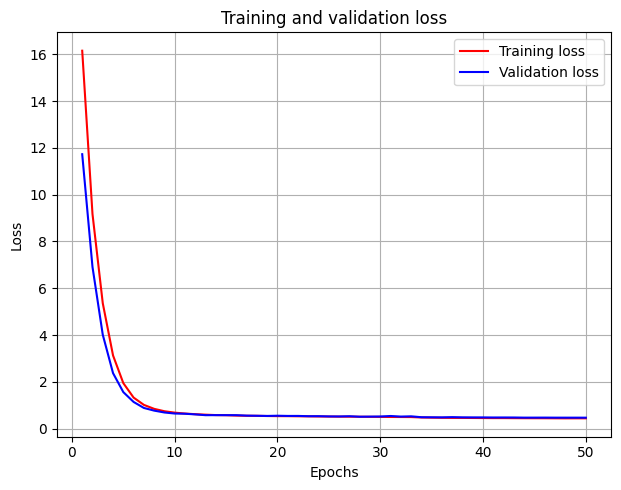

In [24]:
from src.utils.visualization_funcs import visualize_training_results

visualize_training_results(history.history)

## Model Evaluation

### Testing Datasets setup

In [25]:
prepare_test_dataset = AnnotationProcessor(annotation_file= str(TEST_DIR/'_annotations.csv'))
_class_map = {v: k for k, v in enumerate(class_name_list)}
test_image_paths, test_class_ids, test_bboxes = prepare_test_dataset.process_annotations(image_dir=TEST_DIR, class_id_map=_class_map)

len(test_image_paths), len(test_class_ids), len(test_bboxes)

(973, 973, 973)

In [26]:
test_dl = DataLoader(test_image_paths, test_class_ids, test_bboxes, img_size=IMG_SIZE)
test_ds = test_dl.load_val_dataset()
y_true = test_dl.padded_bbx
test_ds = Preprocessor(test_ds).preprocess()
test_ds = test_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

In [27]:
results = model.evaluate(test_ds,return_dict=True)
mlflow.log_metrics(results)
print("Testing accuracy: ", results)

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 360ms/step - iou_metric: 0.5487 - loss: 0.4734 - mse: 0.0970
Testing accuracy:  {'iou_metric': 0.5551902055740356, 'loss': 0.46709805727005005, 'mse': 0.09547960013151169}


In [28]:
pred_bbx = model.predict(test_ds)
pred_bbx[:5]

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 373ms/step


array([[[0.57102966, 0.67886585, 0.7525426 , 0.85906476],
        [0.40549323, 0.572696  , 0.8695322 , 0.9383776 ],
        [0.5551044 , 0.65499073, 0.771339  , 0.8784286 ]],

       [[0.6458384 , 0.14182077, 0.96977884, 0.4666015 ],
        [0.58349717, 0.09465124, 0.98763055, 0.48875764],
        [0.6353385 , 0.13039862, 0.9734533 , 0.47784427]],

       [[0.2568087 , 0.58654445, 0.7266111 , 0.9142656 ],
        [0.18412961, 0.53302175, 0.81948674, 0.9560138 ],
        [0.26031095, 0.5778723 , 0.7292623 , 0.9140648 ]],

       [[0.5841281 , 0.07131132, 0.86955994, 0.335614  ],
        [0.45722365, 0.03477782, 0.94217265, 0.41208968],
        [0.56756526, 0.06251035, 0.8794093 , 0.34999847]],

       [[0.19286983, 0.608827  , 0.601437  , 0.89345074],
        [0.15663816, 0.5869899 , 0.67147017, 0.9306699 ],
        [0.20211901, 0.6046039 , 0.5913484 , 0.88811666]]], dtype=float32)

In [29]:
from src.losses.iou_loss import iou_metric

iou_metric(y_true[0], pred_bbx[0])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.5758884, 0.7761845, 0.6252955], dtype=float32)>

In [30]:
def plot_iou_histogram(y_true_bbox, y_pred_bbox, class_ids):
    """
    Plots a histogram of Intersection over Union (IoU) scores.

    Args:
        y_true_bbox: Ground truth bounding boxes (list of lists or numpy array).
        y_pred_bbox: Predicted bounding boxes (list of lists or numpy array).
        class_ids: list of class ids.
    """
    fig, axs = plt.subplots(1)

    iou_scores = iou_metric(y_true_bbox, y_pred_bbox)

    # fig.figure(figsize=(10, 6))
    axs.hist(iou_scores, bins=20, range=(0, 1), edgecolor='black')
    axs.set_title('IoU Score Distribution')
    axs.set_xlabel('IoU Score')
    axs.set_ylabel('Frequency')
    axs.grid(True)
    plt.show()
    plt.savefig(f"{cfg.OUTPUTS.OUPUT_DIR}/iou_histogram.png")
    return fig


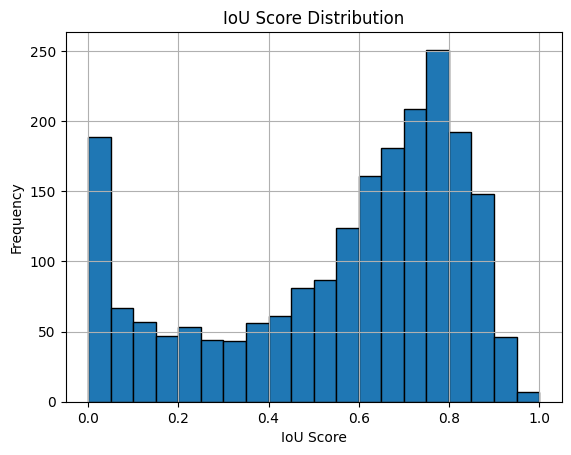

<Figure size 640x480 with 0 Axes>

In [31]:
fig = plot_iou_histogram(y_true, pred_bbx, pred_bbx)
mlflow.log_figure(fig, 'iou_histogram.png')